<a href="https://colab.research.google.com/github/RVel37/stats-UoM/blob/main/Day_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Science - Single Cell RNA sequencing analysis worksheet**

**Initial set up steps**

**1. Change Runtime type to T4 GPU**

**2. Mount your google drive to this google Co-lab session**

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**3. Place the downloaded data 'Hufallopiantube.h5ad' into your google drive**
* You can drag and drop this from your downloads file, into the Files file icon on the left, and navigating to 'drive/MyDrive'


**4. Install additional required packages**

In [40]:
!pip install 'scanpy[leiden]'


**5. Import required packages**

In [41]:
import scanpy as sc
import numpy as np
import pandas as pd

# **1. AnnData as a data object** anndata.svg


We will explore a small single cell RNA sequencing dataset of Fallopian Tube cells. The dataset includes benign samples from 5 patients , and high grade serous ovarian carcinoma (HGOC) samples from 5 patients.

High-grade serous ovarian cancer (HGOC) is the most common and aggressive type of epithelial ovarian cancer.

It is hypothesised to originate from Serous tubal intraepithelial carcinoma (STIC) cells in the fallopian tube.


**1. Read in data to create an Anndata object**


In [42]:
hu = sc.read_h5ad('/content/drive/MyDrive/datascience_course/Hufallopiantube.h5ad')

**2. View the structure of the data**

In [43]:
hu.layers["counts"] = hu.X.copy()

**3. View the meta data**

In [44]:
hu.obs

,Patient,Author,Tissue,Disease_stage,Age
CellID,,,,,
sc_b1_A08,33572,Hu_2020,Benign fallopian tube cells,Benign,64
sc_b1_B06,34350,Hu_2020,Benign fallopian tube cells,Benign,50
sc_b1_B08,34350,Hu_2020,Benign fallopian tube cells,Benign,50
sc_b1_B11,34350,Hu_2020,Benign fallopian tube cells,Benign,50
sc_b1_C15,34350,Hu_2020,Benign fallopian tube cells,Benign,50
...,...,...,...,...,...
15072R-p1-B17,15072,Hu_2020,HGSOC fallopian tube cells,IIIc1,62
15072R-p1-B18,15072,Hu_2020,HGSOC fallopian tube cells,IIIc1,62
15072R-p1-C01,15072,Hu_2020,HGSOC fallopian tube cells,IIIc1,62


**4. View the highest expressed genes**

  Using sc.pl.highest_expr_genes(data, n_top=int)

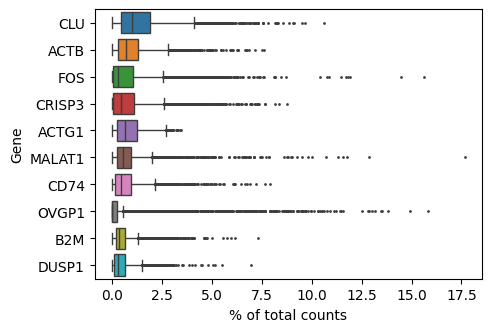

In [45]:
sc.pl.highest_expr_genes(hu, n_top = 10 )

# **2. Filtering of the data**


**1. Filter out cells which have less than 100 genes expressed, and genes which are expressed in less than 3 cells.**

Use the scanpy commands:

* sc.pp.filter_cells(data, min_genes= *int*)
* sc.pp.filter_genes(data, min_cells= *int*)



In [46]:
sc.pp.filter_cells(hu, min_genes=10)
sc.pp.filter_genes(hu, min_cells=10)

**2.Calculate quality control metrics**

* sc.pp.calculate_qc_metrics(data, percent_top=(50,
100,200,500),inplace=True, log1p=False, )

In [47]:
sc.pp.calculate_qc_metrics(hu,percent_top=(50,100,200,500), inplace=True, log1p=False)

**3. View quality control metrics in a violin plot**
* sc.pl.violin(data, ['n_genes_by_counts','total_counts'],jitter=0.4, multi_panel=True)

Violin plot = distributions of numeric data for one or more groups using density curves. The width of each curve corresponds with the approximate frequency of data points in each region. Densities are frequently accompanied by an overlaid chart type, such as box plot, to provide additional information.

https://www.atlassian.com/data/charts/violin-plot-complete-guide#:~:text=A%20violin%20plot%20depicts%20distributions,plot%2C%20to%20provide%20additional%20information.

First one is gene expression per cell
Second one is raw counts per gene

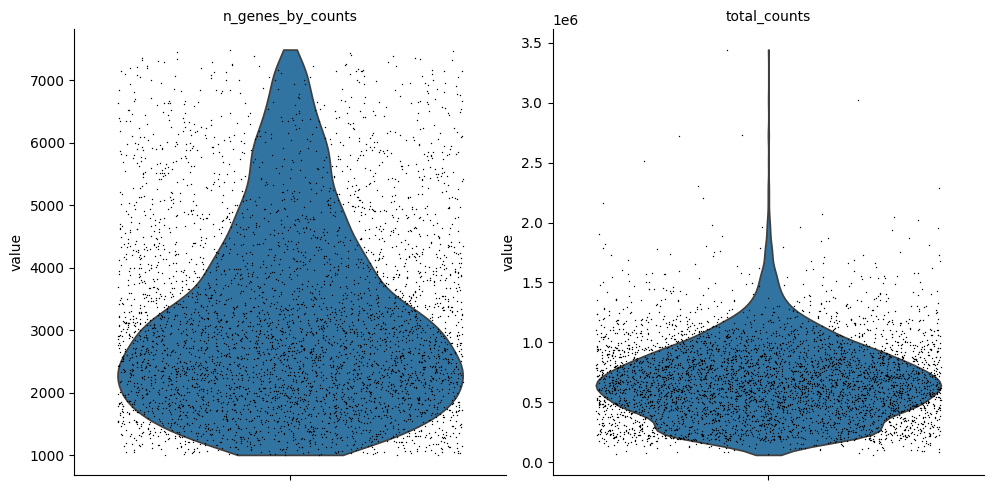

In [48]:
sc.pl.violin(hu, ['n_genes_by_counts','total_counts'],jitter=0.4, multi_panel=True)

**4.Filter the cells further by slicing the anndata object on 'n_genes_by_counts' <6000 and 'total_counts' <1500000**

For n_genes_by_counts (remove cells with a high number of detected genes) this would be:
* data=data[data.obs.n_genes_by_counts <6000,:]


In [49]:
hu=hu[hu.obs.n_genes_by_counts < 6000,:]
hu=hu[hu.obs.total_counts < 1500000,:]

**5.View the structure of the data after filtering steps**

In [50]:
hu

View of AnnData object with n_obs × n_vars = 4231 × 18469
    obs: 'Patient', 'Author', 'Tissue', 'Disease_stage', 'Age', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

# **3.Dimensionality Reduction and visualisation**
To plot the data in a UMAP,


1. Initial pre-processing steps:
* Normalise the counts per cell, so each cell has 10,000 counts
* log transform the data

2.   Identify and crop the data to only the highly variable genes, then scale the data
3.   Compute the PCA
4.   Compute the Nearest neighbours graph
5.   Compute the UMAP




**1.Normalise and log transform the data**
* sc.pp.normalize_total(data, target_sum=1e4)
* sc.pp.log1p(data)

In [51]:
sc.pp.normalize_total(hu,target_sum=1e4)
sc.pp.log1p(hu)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


**2.Crop the data to highly variable genes only**
* sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
* sc.pl.highly_variable_genes(data)
* data.raw = data
* data = data [:, data.var.highly_variable]
* sc.pp.scale(data, max_value=10)

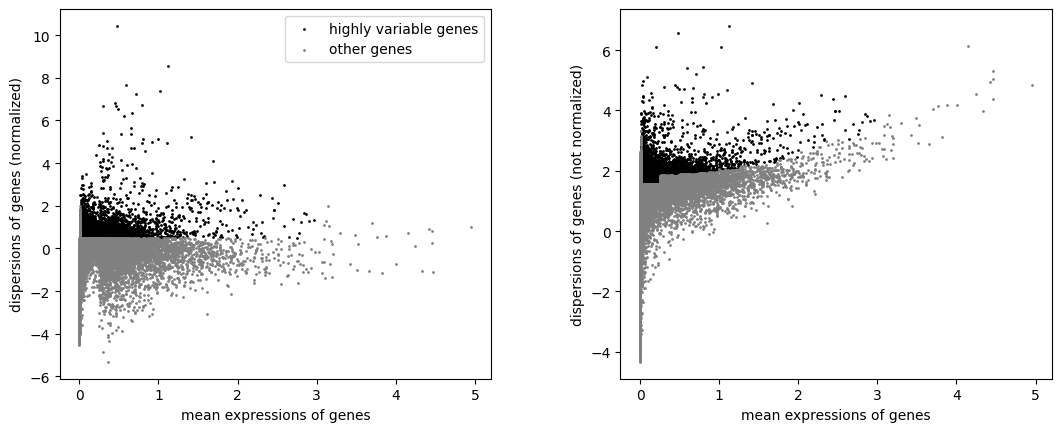

In [52]:
sc.pp.highly_variable_genes(hu, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(hu)

**3.Calculate and plot a principal component analysis (PCA) elbow plot**

(tl = "tool", pl = "plot")

* sc.tl.pca(data, svd_solver='arpack')
* sc.pl.pca_variance_ratio(data, log=True)
* sc.pl.pca(data, color=[' '])

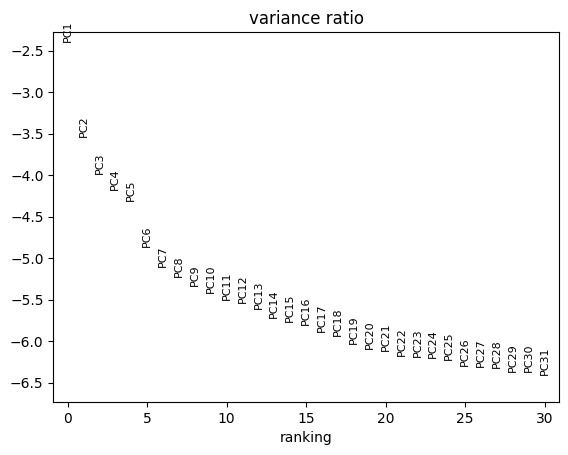

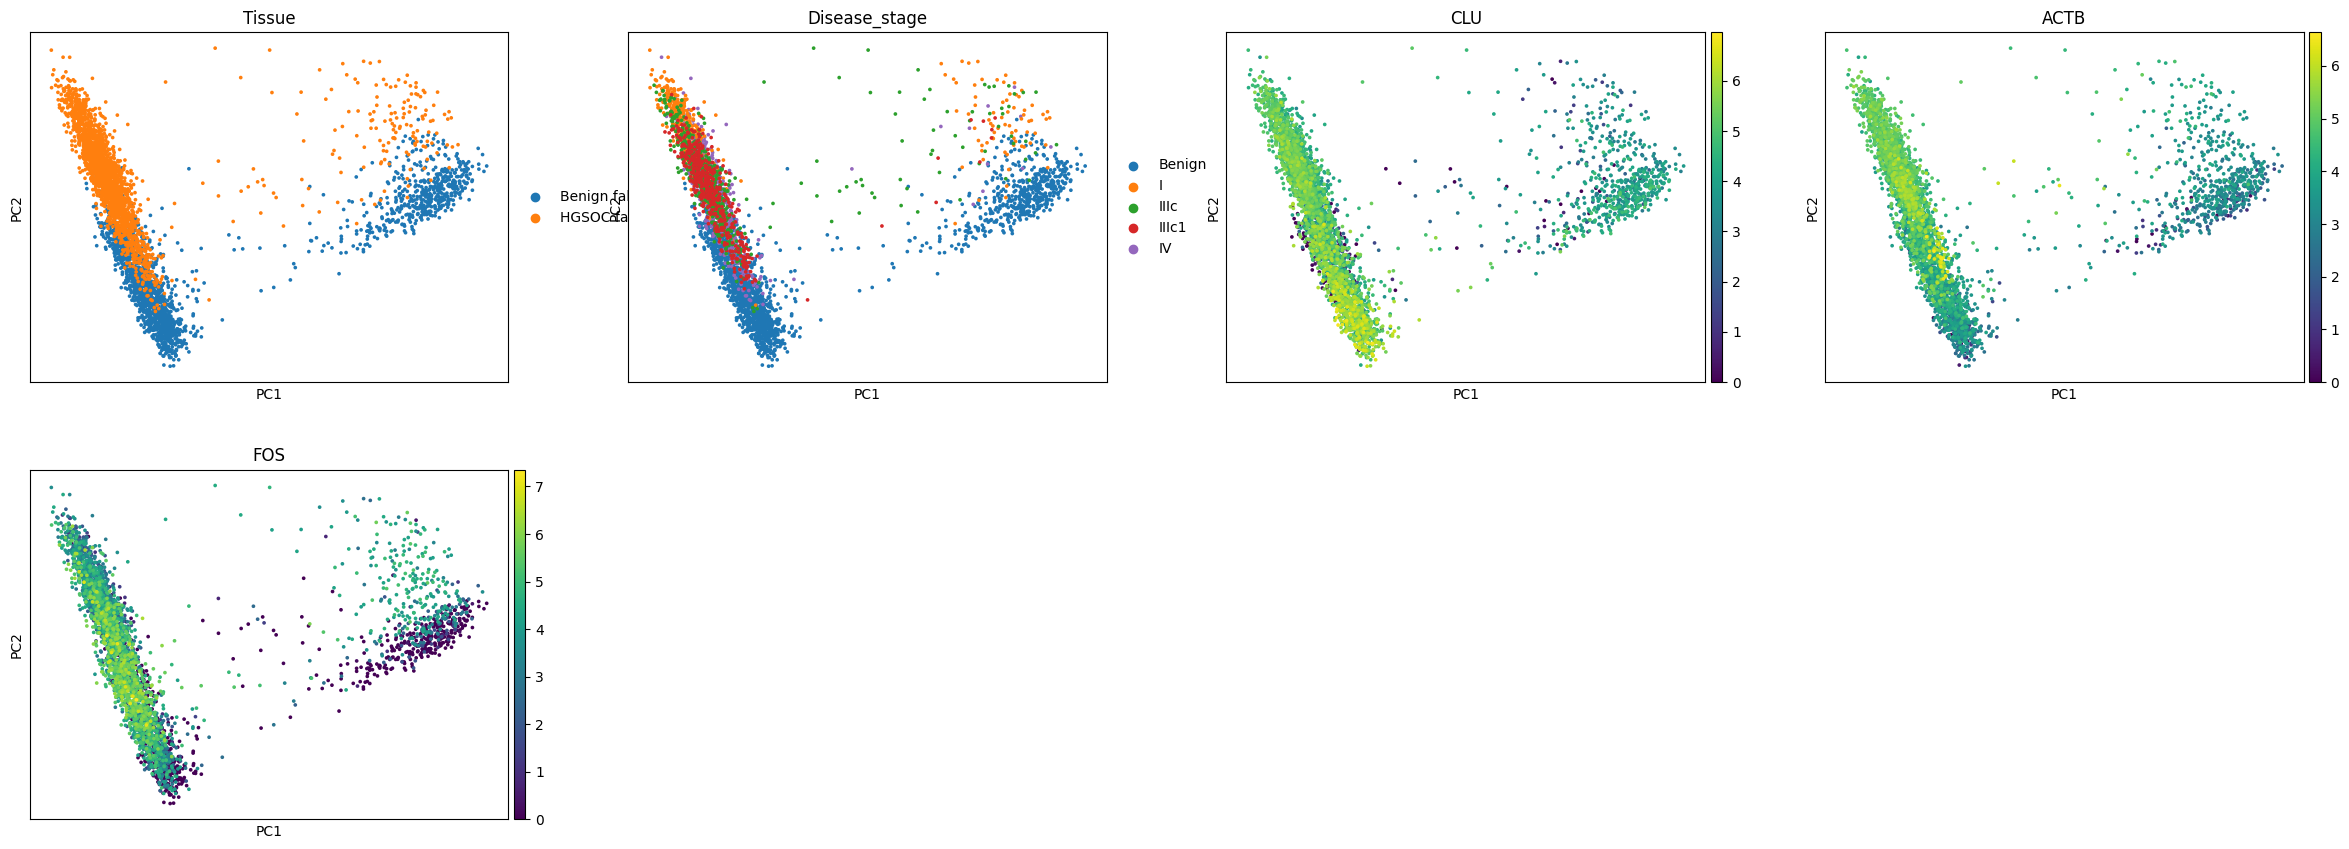

In [53]:
sc.tl.pca(hu, svd_solver='arpack')
sc.pl.pca_variance_ratio(hu, log=True)
sc.pl.pca(hu, color=['Tissue','Disease_stage','CLU','ACTB','FOS'])

**4.Compute the nearest neighbours graph, choose the number of principal components to use based on the elbow of the PCA plot (inflection point)**
 * sc.pp.neighbors(data, n_pcs= )

In [54]:
sc.pp.neighbors(hu, n_pcs=8) # 8 = the elbow
 # looking at graph above this is where it takes a sharp turn from vertical ish to more horizontal. so we want to include the first 8 before this turn

**5.Compute and plot the UMAP**
* sc.tl.umap(data)

Plot the UMAP by Tissue, or another value of.obs columns
* sc.pl.umap(data, color=[''])


In [57]:
sc.tl.umap(hu)


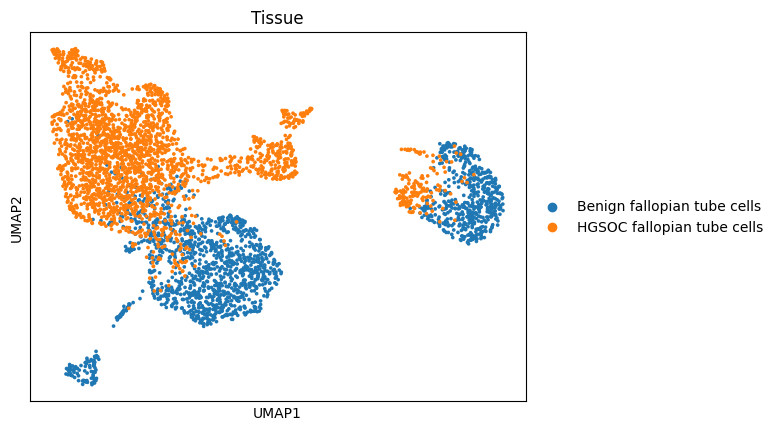

In [58]:
sc.pl.umap(hu, color=['Tissue'])


Plot the UMAP in the color of gene expression (use one of the genes from top 20 highly expressed genes)

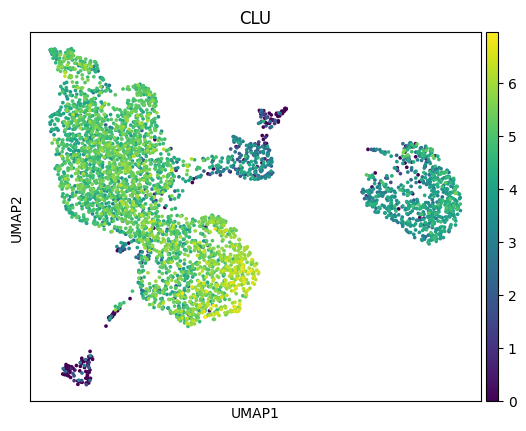

In [59]:
sc.pl.umap(hu, color = ['CLU'])

**6.Examine how the UMAP structure changes when you change the number of pcs used to generate the n_neighbours graph**

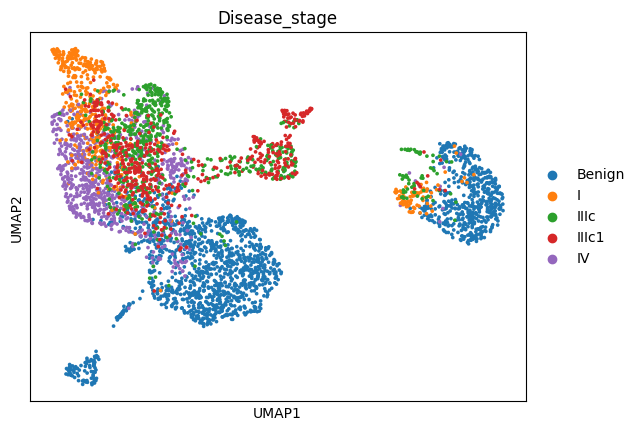

In [60]:
sc.pp.neighbors(hu, n_pcs=2)
sc.pl.umap(hu, color=['Disease_stage'])


**7. Re-run the nearest neighbours graph and UMAP with optimal number of PCs**

# **5.Leiden clustering**
Cluster the cells to identify similar groups of cells
* By examining gene expression, determine what type of cells are in each cluster
* Using a dictionary, create a new obs. column assigning a label of cell type to leiden clusters
* Test the top differentially expressed genes in each leiden cluster/cell type
* Plot a heatmap of top differentially expressed genes in each leiden cluster/cell type

**1. Perform leiden clustering, then visualise clusters on the UMAP**
* sc.tl.leiden(data, resolution=0.2)
* sc.pl.umap(data, color=['leiden'])

**2. Calculate the top differentially expressed genes in each leiden cluster**
* sc.tl.rank_genes_groups(data,'leiden', method='wilcoxon')
* sc.pl.rank_genes_groups(data, n_genes=25)

**3. Export the ranked genes, with scores to a csv file (we will come back to these tomorrow)**

In [ ]:
topmarkers=hu.uns['rank_genes_groups']
groups = topmarkers['names'].dtype.names
celltypemarkergenes = pd.DataFrame({group +'_'+key[:1]:topmarkers[key][group]
              for group in groups for key in ['names','scores']})

celltypemarkergenes.to_csv(r'/content/drive/MyDrive/datascience_course/celltypemarkergenes.csv', index=False)

celltypemarkergenes

**3. Plot top 20 differentially expressed genes in a heatmap**

* sc.pl.rank_genes_groups_heatmap(data, n_genes=20, swap_axes=True, show_gene_labels=False, vmin=-3, vmax=3 )

**4. Visualise marker genes to determine the cell types present in each cluster**

Secretory Epithelial : OVGP1

Ciliated Epithelial : FOXJ1, PIFO

Immune: PTPRC

Fibroblast: COL1A1, DCN

STIC lesion : KRT17


* sc.pl.violin(data, ['EPCAM','OVGP1','...'], groupby = 'leiden')


**5. From these markers, it is still unclear what cell types some of the leiden clusters are**

Look up some of the top marker genes for these clusters to determine what cell types they are.

**6. Create a dictionary defining Leiden clusters and their respective cell type**

Create a new .obs column to store the cell types , and map this to leiden clusters using the dictionary,

Which cluster represents high grade carcinoma cells?

```
celltypedict = {
        '0' : 'Secretory Epithelial',
        '1' : 'Fibroblast' }

data.obs['Celltype'] = hu.obs['leiden'].map(celltypedict)


**7. Plot a UMAP colored by cell types**

## **6. Querying GWAS catalog API**


As these women were diagnosed with ovarian cancers, we can use the GWAS catalog to look at the expression of genes associated with epithelial carcinomas

Use the packages: 'requests' and 'json'

Make a get request to the API for the association data from study no. GCST003588, the https address to use is "https://www.ebi.ac.uk/gwas/rest/api/studies/GCST003588/associations"





**3. We can use the GWAS catalog obtain a list of genes associated with high grade serous ovarian carcinoma**


In [ ]:
import requests
import json

In [ ]:
response=requests.get("https://www.ebi.ac.uk/gwas/rest/api/studies/GCST003588/associations")
response.json()

**4.Make a Pandas dataframe containing 'riskAlleleName' and 'geneName'**
* If you don't know how to do this, solution is in the 'geneIdsjson.py' file in the Github repository

**5. To plot the gene expression of carcinoma GWAS genes, convert this to a list**
* genes=[gene for gene in gwasgenes['geneName'].tolist() if gene !='Intergenic' and gene in hu.raw.var_names]

**6. Plot gene expression of Carcinoma GWAS genes per leiden cluster in a dot plot**
* sc.pl.dotplot()


**7. Plot gene expression of the highly expressed carcinoma GWAS genes in a UMAP, compare this to a UMAP of Disease Stage**

In [ ]:
sc.pl.umap(hu, color=['leiden','Disease_stage','TUBA1C','KRT8','HLA-C'])

## **6. Subsetting secretory epithelial cells**
As HGOC is thought to originate from epithelial cells in the fallopian tube, we can examine epithelial cells in greater depth by creating a subset of the data of epithelial cells.

**1. Create new object of a subset of epithelial cell data**
* subset = data[data.obs['Celltype'].isin([''])]

**2. Run the dimensionality reduction and clustering analysis again to identify clusters of epitheilal cells**